In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA

from mydatools.plot import plot_grid_search_result

% matplotlib inline

In [2]:
train_df = pd.read_csv('./data/input/train.csv')
test_df = pd.read_csv('./data/input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

dropoff_datetime  dropoff_latitude  dropoff_longitude         id  \
train 0  2016-03-14 17:32:30         40.765602         -73.964630  id2875421   
      1  2016-06-12 00:54:38         40.731152         -73.999481  id2377394   
      2  2016-01-19 12:10:48         40.710087         -74.005333  id3858529   
      3  2016-04-06 19:39:40         40.706718         -74.012268  id3504673   
      4  2016-03-26 13:38:10         40.782520         -73.972923  id2181028   

         passenger_count      pickup_datetime  pickup_latitude  \
train 0                1  2016-03-14 17:24:55        40.767937   
      1                1  2016-06-12 00:43:35        40.738564   
      2                1  2016-01-19 11:35:24        40.763939   
      3                1  2016-04-06 19:32:31        40.719971   
      4                1  2016-03-26 13:30:55        40.793209   

         pickup_longitude store_and_fwd_flag  trip_duration  vendor_id  
train 0        -73.982155                  N          455.0          2  
      1        -73.980415                  N          663.0          1  
      2        -73.979027                  N         2124.0          2  
      3        -74.010040                  N          429.0          2  
      4        -73.973053                  N          435.0          2

In [3]:
full_df['log1p_trip_duration'] = np.log1p(full_df['trip_duration'])

## feature

In [4]:
feature_columns = [
    'passenger_count', 'vendor_id',
    'store_and_fwd_flag',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude', 
]

In [5]:
def add_features(features):
    if type(features) != list:
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

In [6]:
full_df['store_and_fwd_flag'] = full_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

* generate datetime features

In [7]:
def gen_datetime_feature(prefix):
    # datetime features
    f_datetime = prefix + '_datetime'
    attr_list = [
#         'year', 
        'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear',
        'hour', 'minute',
    ]

    full_df[f_datetime] = pd.to_datetime(full_df[f_datetime])
    for attr in attr_list:
        full_df[prefix+'_'+attr] = eval("full_df[f_datetime].dt."+attr)
        add_features(prefix+'_'+attr)
    
    full_df[prefix+'_hour_minute'] = full_df[prefix+'_hour'] * 60 + full_df[prefix+'_minute']
    full_df[prefix+'_week_hour'] = full_df[prefix+'_dayofweek'] * 24 + full_df[prefix+'_hour']
    full_df[prefix+'_week_hour_minute'] = full_df[prefix+'_week_hour'] * 60 + full_df[prefix+'_minute']
    full_df[prefix+'_total_seconds'] = (full_df[f_datetime] - full_df[f_datetime].min()).dt.total_seconds()
    add_features([
        prefix+'_hour_minute', prefix+'_week_hour',
        prefix+'_week_hour_minute', prefix+'_total_seconds',
    ])
    
    full_df[prefix+'_date'] = full_df[f_datetime].dt.date

gen_datetime_feature('pickup')
# gen_datetime_feature('dropoff') # 注意 这个不能用 下车时间是结果的一个信息

* riding distance

In [8]:
xy_distance = np.c_[
    (full_df['dropoff_latitude'] - full_df['pickup_latitude']).values,
    (full_df['dropoff_longitude'] - full_df['pickup_longitude']).values,
]
full_df['distance_p2'] = np.linalg.norm(xy_distance, 2, axis=1)
full_df['distance_p1'] = np.linalg.norm(xy_distance, 1, axis=1)
add_features(['distance_p2', 'distance_p1'])

* pos(longitude/latitude) speed

In [9]:
min_longitude, max_longitude = -74.5, -73.5
min_latitude, max_latitude = 40.4, 41.1
    
pos_feats = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

将经纬度分割成一格一格 每一格取速度平均值

In [10]:
# 分割的间隔
pos_interval = 0.01
max_longitude_idx = int((max_longitude - min_longitude) // 0.01)
max_latitude_idx = int((max_latitude - min_latitude) // 0.01)

# 获取每条数据的pos_idx
for posf in pos_feats:
    pos_type = posf.split('_')[1]
    min_v, max_v = eval('min_'+pos_type), eval('max_'+pos_type)
    idx_df = (full_df[posf].clip(min_v, max_v) - min_v) // pos_interval
    idx_df = np.where(idx_df > 0, idx_df, 0) # 没有这个操作会有负数
    full_df['idx_'+posf] = idx_df.astype('int')

In [11]:
# 速度
full_df['speed'] = (full_df['distance_p2'] / full_df['trip_duration'] * 3600).clip(0, 1)
full_df['speed_p1'] = (full_df['distance_p1'] / full_df['trip_duration'] * 3600).clip(0, 1)

In [12]:
# 将df扩充至(0,max_index)和(0,max_columns)
def get_dense_df(df, max_index, max_columns):
    res_df = pd.DataFrame(np.zeros((max_index, max_columns)))
    res_df.iloc[df.index.astype(int), df.columns.astype(int)] = df.values
    return res_df

In [13]:
# 获取上车/下车地点速度（根据train数据）
pickup_speed_dist = full_df.loc['train'].groupby(['idx_pickup_longitude', 'idx_pickup_latitude'])['speed'].mean().unstack()
dropoff_speed_dist = full_df.loc['train'].groupby(['idx_dropoff_longitude', 'idx_dropoff_latitude'])['speed'].mean().unstack()
pickup_speed_dist = get_dense_df(pickup_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values
dropoff_speed_dist = get_dense_df(dropoff_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values

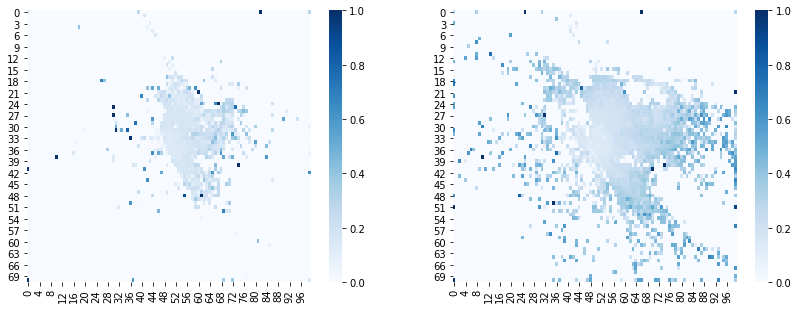

In [14]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

sns.heatmap(pickup_speed_dist.T, cmap=plt.cm.Blues, ax=ax[0])
sns.heatmap(dropoff_speed_dist.T, cmap=plt.cm.Blues, ax=ax[1])

In [15]:
# 根据train的位置速度 计算train/test的位置速度

# 这个方法太慢了
# full_df['pickup_pos_speed'] = full_df.apply(lambda df: pickup_speed_dist.values[df['idx_pickup_longitude'], df['idx_pickup_latitude']], axis=1)

full_df['pickup_pos_speed'] = 0
full_df['dropoff_pos_speed'] = 0

# for i in range(max_longitude_idx+1):
#     pickup_cond1 = (full_df['idx_pickup_longitude'] == i)
#     dropoff_cond1 = (full_df['idx_dropoff_longitude'] == i)

#     for j in range(max_latitude_idx+1):
#         pickup_cond2 = (full_df['idx_pickup_latitude'] == j)
#         dropoff_cond2 = (full_df['idx_dropoff_latitude'] == j)
        
#         full_df.loc[pickup_cond1 & pickup_cond2, 'pickup_pos_speed'] = pickup_speed_dist[i][j]
#         full_df.loc[dropoff_cond1 & dropoff_cond2, 'dropoff_pos_speed'] = dropoff_speed_dist[i][j]
        
# full_df[['pickup_pos_speed', 'dropoff_pos_speed']].to_csv('./data/input/tmp_pos_speed.csv', index=False)

full_df[['pickup_pos_speed', 'dropoff_pos_speed']] = pd.read_csv('./data/input/tmp_pos_speed.csv').values

add_features(['pickup_pos_speed', 'dropoff_pos_speed'])

In [16]:
# 计算起点到终点范围内的速度

full_df['range_speed_by_pickup_speed'] = 0
full_df['range_speed_by_dropoff_speed'] = 0

# # 计算哪些位置是非0的
# pickup_speed_dist_isnotnan = np.where(pickup_speed_dist == 0, 0, 1)
# dropoff_speed_dist_isnotnan = np.where(dropoff_speed_dist == 0, 0, 1)

# full_df['min_idx_longitude'] = full_df[['idx_pickup_longitude', 'idx_dropoff_longitude']].min(axis=1)
# full_df['max_idx_longitude'] = full_df[['idx_pickup_longitude', 'idx_dropoff_longitude']].max(axis=1)
# full_df['min_idx_latitude'] = full_df[['idx_pickup_latitude', 'idx_dropoff_latitude']].min(axis=1)
# full_df['max_idx_latitude'] = full_df[['idx_pickup_latitude', 'idx_dropoff_latitude']].max(axis=1)

# full_df['range_speed_by_pickup_speed'] = full_df.apply(
#     lambda df: 
#         pickup_speed_dist[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum() / 
#         pickup_speed_dist_isnotnan[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum(),
#     axis=1).fillna(0)

# full_df['range_speed_by_dropoff_speed'] = full_df.apply(
#     lambda df: 
#         dropoff_speed_dist[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum() / 
#         dropoff_speed_dist_isnotnan[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum(),
#     axis=1).fillna(0)

# full_df[['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed']].to_csv('./data/input/tmp_range_speed.csv', index=False)

full_df[['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed']] = pd.read_csv('./data/input/tmp_range_speed.csv').values

add_features(['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed'])

* PCA coordinates

对坐标PCA后，虽然维度没有变，仍然是2D，但是有助于树模型分类

In [17]:
coords = np.vstack((
    full_df[['pickup_latitude', 'pickup_longitude']].values,
    full_df[['dropoff_latitude', 'dropoff_longitude']].values,
))

pca = PCA().fit(coords)

new_feats = ['pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1']
for f in new_feats:
    full_df[f] = 0

full_df[['pickup_pca0', 'pickup_pca1']] = pca.transform(full_df[['pickup_latitude', 'pickup_longitude']])
full_df[['dropoff_pca0', 'dropoff_pca1']] = pca.transform(full_df[['dropoff_latitude', 'dropoff_longitude']])

add_features(new_feats)

## EDA

In [18]:
tdf = full_df.copy()

tdf = tdf[tdf['trip_duration'] < 500000]
tdf = tdf[tdf['pickup_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['pickup_latitude'].between(min_latitude, max_latitude)]
tdf = tdf[tdf['dropoff_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['dropoff_latitude'].between(min_latitude, max_latitude)]

* 上车/下车地点分布

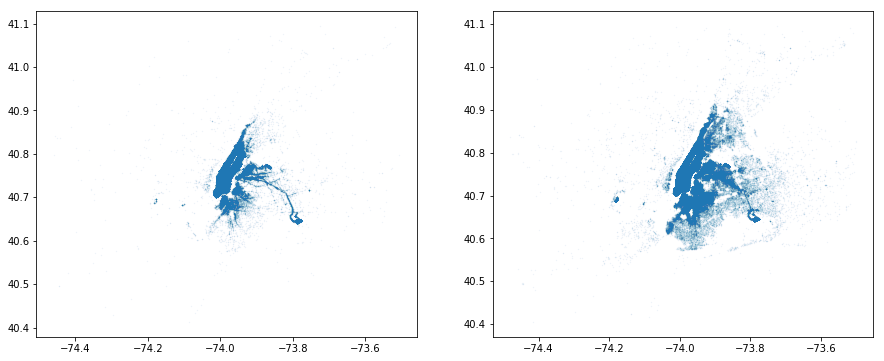

In [19]:
plt.subplots(1, 2, figsize=(15,6))

plt.subplot(121)
plt.scatter(tdf['pickup_longitude'], tdf['pickup_latitude'], s=0.1, alpha=0.1)

plt.subplot(122)
plt.scatter(tdf['dropoff_longitude'], tdf['dropoff_latitude'], s=0.1, alpha=0.1)

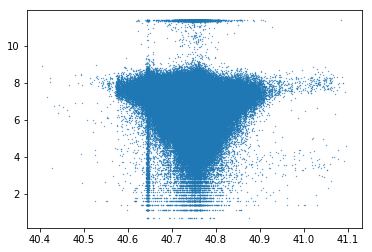

In [20]:
# plt.scatter(tdf['distance'], tdf['log1p_trip_duration'], s=0.1) # 这个有明显的关系
plt.scatter(tdf['dropoff_latitude'], tdf['log1p_trip_duration'], s=0.1)

* 可以看到 不同的位置 行驶的速度还是有区别的 

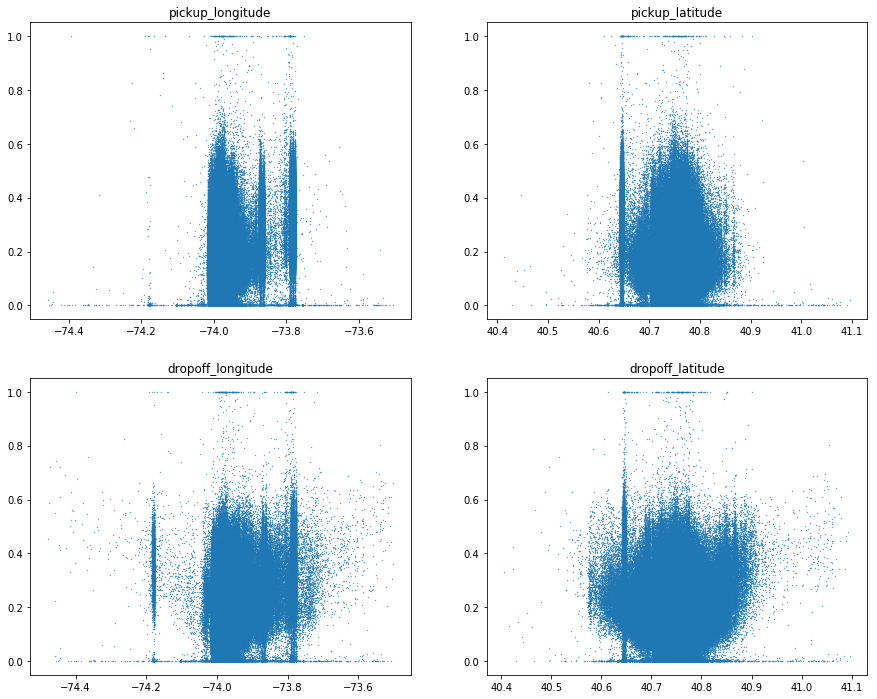

In [21]:
def show_pos(df, f):
    plt.subplots(2, 2, figsize=(15,12))
 
    for i, posf in enumerate(pos_feats):
        plt.subplot(2,2,i+1)
        plt.scatter(tdf[posf], tdf[f], s=0.1)
        plt.title(posf)
        
show_pos(tdf, 'speed')

* 速度跟周几还是很有关系的

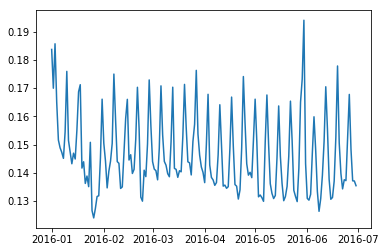

In [22]:
plt.plot(tdf.groupby(tdf['pickup_datetime'].dt.date)['speed'].mean())

* 不同的vendor_id速度是基本一样的，但是vendor_id=1比较偏向于接时间短的单子

In [23]:
vendor_date_speed_df = tdf.groupby([tdf['vendor_id'], tdf['pickup_date']], as_index=False)[['log1p_trip_duration', 'speed']].mean()

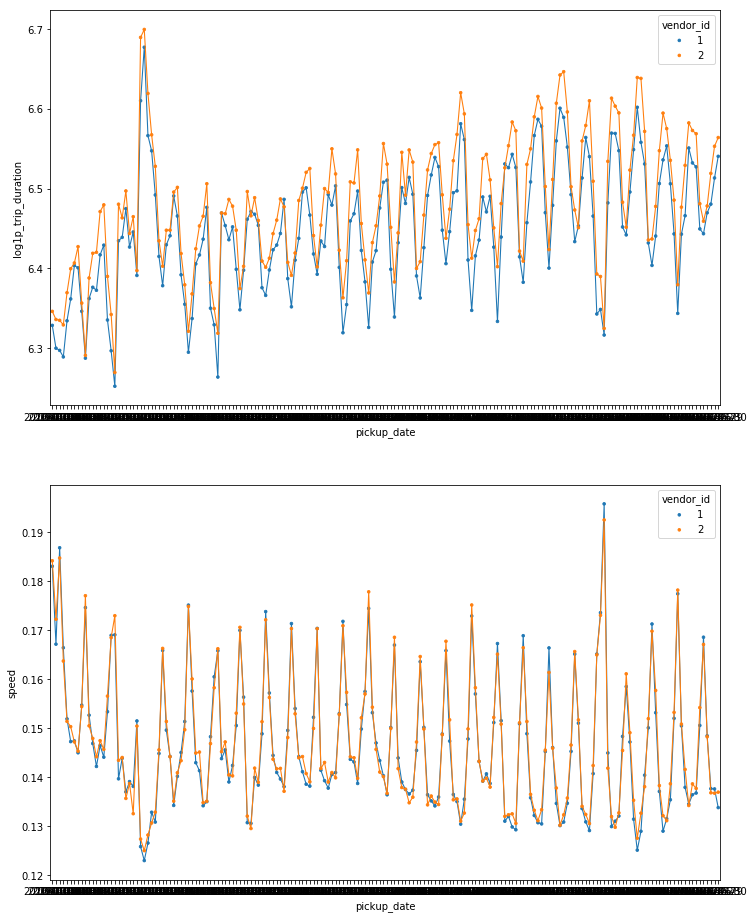

In [24]:
fig, ax = plt.subplots(2,1,figsize=(12,16))
sns.pointplot('pickup_date', 'log1p_trip_duration', 'vendor_id', data=vendor_date_speed_df, scale=0.4, ax=ax[0])
sns.pointplot('pickup_date', 'speed', 'vendor_id', data=vendor_date_speed_df, scale=0.4, ax=ax[1])

* 日订单数

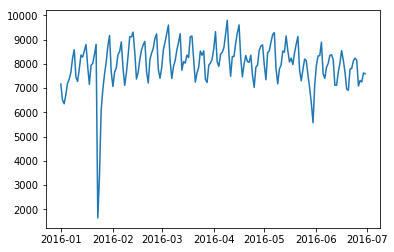

In [25]:
plt.plot(tdf.groupby(tdf['pickup_datetime'].dt.date).size())

## 相关性

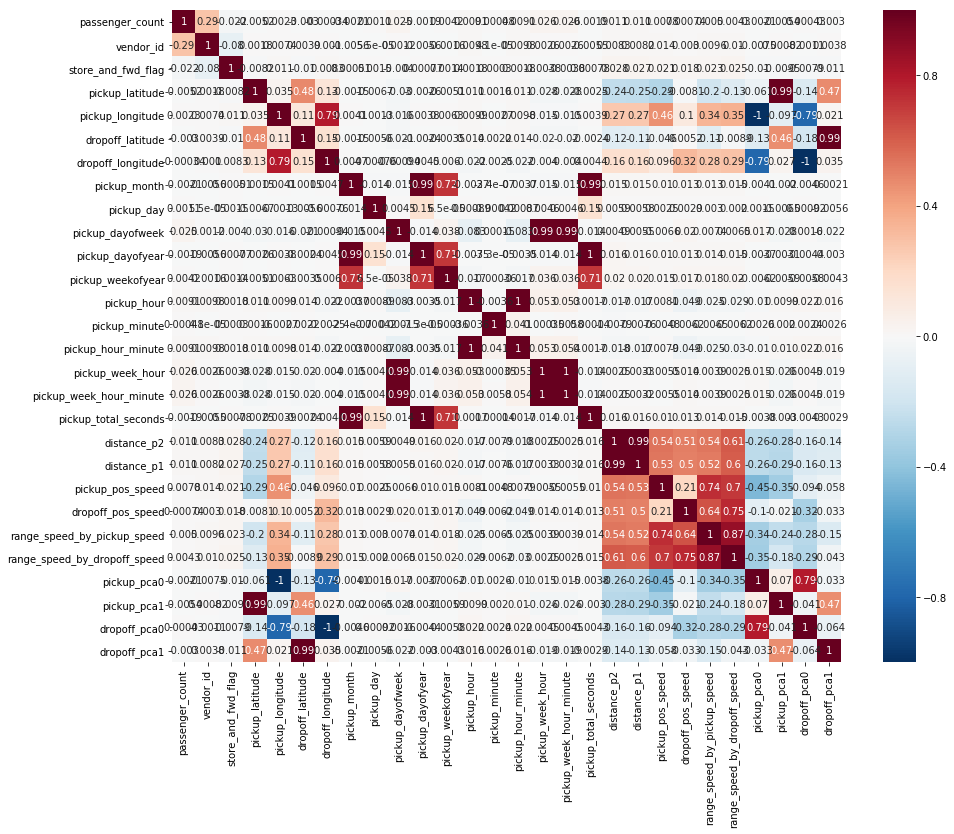

In [26]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
corr_df = full_df[feature_columns].corr()
sns.heatmap(corr_df, annot=True, cmap=plt.cm.RdBu_r)

## 预处理

In [27]:
trn_df = full_df.loc['train']
tst_df = full_df.loc['test']

X = trn_df[feature_columns].values
y = trn_df['log1p_trip_duration'].values
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns].values
# y_tst = tst_df['log1p_trip_duration'].values

trn_lgb = lgb.Dataset(X_trn, y_trn, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, y_val, free_raw_data=False, reference=trn_lgb)

## LightGBM

In [28]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.2,
#     'max_depth': 5,
#     'num_leaves': 20,
#     'subsample': 0.8,
#     'colsample_bytree': 0.5,
#     'min_child_weight': 3, 
#     'min_child_samples': 6,
#     'reg_alpha': 0.01,
    'verbose': 1,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)
bst.save_model('./data/output/model.txt')

[1]	training's rmse: 0.699097	valid_1's rmse: 0.697027
Train until valid scores didn't improve in 20 rounds.
[2]	training's rmse: 0.627673	valid_1's rmse: 0.625675
[3]	training's rmse: 0.5761	valid_1's rmse: 0.574192
[4]	training's rmse: 0.539138	valid_1's rmse: 0.537239
[5]	training's rmse: 0.513388	valid_1's rmse: 0.511624
[6]	training's rmse: 0.49377	valid_1's rmse: 0.492095
[7]	training's rmse: 0.480325	valid_1's rmse: 0.478701
[8]	training's rmse: 0.470638	valid_1's rmse: 0.469058
[9]	training's rmse: 0.463198	valid_1's rmse: 0.461698
[10]	training's rmse: 0.457638	valid_1's rmse: 0.456188
[11]	training's rmse: 0.453484	valid_1's rmse: 0.45199
[12]	training's rmse: 0.449845	valid_1's rmse: 0.44841
[13]	training's rmse: 0.447021	valid_1's rmse: 0.445644
[14]	training's rmse: 0.444865	valid_1's rmse: 0.443498
[15]	training's rmse: 0.442666	valid_1's rmse: 0.441328
[16]	training's rmse: 0.440977	valid_1's rmse: 0.439744
[17]	training's rmse: 0.439369	valid_1's rmse: 0.438147
[18]	tra

[147]	training's rmse: 0.397978	valid_1's rmse: 0.404367
[148]	training's rmse: 0.397898	valid_1's rmse: 0.404338
[149]	training's rmse: 0.397769	valid_1's rmse: 0.404218
[150]	training's rmse: 0.397631	valid_1's rmse: 0.404098
[151]	training's rmse: 0.39751	valid_1's rmse: 0.40406
[152]	training's rmse: 0.397384	valid_1's rmse: 0.403957
[153]	training's rmse: 0.397249	valid_1's rmse: 0.403823
[154]	training's rmse: 0.397122	valid_1's rmse: 0.40377
[155]	training's rmse: 0.397036	valid_1's rmse: 0.403729
[156]	training's rmse: 0.396896	valid_1's rmse: 0.403613
[157]	training's rmse: 0.396759	valid_1's rmse: 0.403546
[158]	training's rmse: 0.39664	valid_1's rmse: 0.403486
[159]	training's rmse: 0.396456	valid_1's rmse: 0.403313
[160]	training's rmse: 0.396344	valid_1's rmse: 0.403294
[161]	training's rmse: 0.396242	valid_1's rmse: 0.403245
[162]	training's rmse: 0.396154	valid_1's rmse: 0.403185
[163]	training's rmse: 0.395978	valid_1's rmse: 0.403026
[164]	training's rmse: 0.395794	val

[293]	training's rmse: 0.38384	valid_1's rmse: 0.397321
[294]	training's rmse: 0.383753	valid_1's rmse: 0.397294
[295]	training's rmse: 0.383692	valid_1's rmse: 0.397287
[296]	training's rmse: 0.383637	valid_1's rmse: 0.397259
[297]	training's rmse: 0.383569	valid_1's rmse: 0.397268
[298]	training's rmse: 0.38347	valid_1's rmse: 0.397213
[299]	training's rmse: 0.383429	valid_1's rmse: 0.397203
[300]	training's rmse: 0.383394	valid_1's rmse: 0.397205
[301]	training's rmse: 0.383332	valid_1's rmse: 0.397175
[302]	training's rmse: 0.383253	valid_1's rmse: 0.397175
[303]	training's rmse: 0.383161	valid_1's rmse: 0.39718
[304]	training's rmse: 0.383107	valid_1's rmse: 0.397193
[305]	training's rmse: 0.383061	valid_1's rmse: 0.397173
[306]	training's rmse: 0.383018	valid_1's rmse: 0.397176
[307]	training's rmse: 0.382937	valid_1's rmse: 0.39715
[308]	training's rmse: 0.382875	valid_1's rmse: 0.3971
[309]	training's rmse: 0.382821	valid_1's rmse: 0.397071
[310]	training's rmse: 0.382791	valid

[439]	training's rmse: 0.375571	valid_1's rmse: 0.394699
[440]	training's rmse: 0.375502	valid_1's rmse: 0.394686
[441]	training's rmse: 0.375455	valid_1's rmse: 0.394651
[442]	training's rmse: 0.375414	valid_1's rmse: 0.394639
[443]	training's rmse: 0.375358	valid_1's rmse: 0.394623
[444]	training's rmse: 0.375316	valid_1's rmse: 0.394626
[445]	training's rmse: 0.375268	valid_1's rmse: 0.394624
[446]	training's rmse: 0.375257	valid_1's rmse: 0.394621
[447]	training's rmse: 0.375159	valid_1's rmse: 0.39456
[448]	training's rmse: 0.375064	valid_1's rmse: 0.394482
[449]	training's rmse: 0.375024	valid_1's rmse: 0.39447
[450]	training's rmse: 0.37497	valid_1's rmse: 0.394442
[451]	training's rmse: 0.374906	valid_1's rmse: 0.394409
[452]	training's rmse: 0.37487	valid_1's rmse: 0.394385
[453]	training's rmse: 0.374804	valid_1's rmse: 0.394327
[454]	training's rmse: 0.37476	valid_1's rmse: 0.394317
[455]	training's rmse: 0.374734	valid_1's rmse: 0.394327
[456]	training's rmse: 0.374699	vali

[586]	training's rmse: 0.368486	valid_1's rmse: 0.392633
[587]	training's rmse: 0.368439	valid_1's rmse: 0.39264
[588]	training's rmse: 0.368396	valid_1's rmse: 0.392622
[589]	training's rmse: 0.368328	valid_1's rmse: 0.392634
[590]	training's rmse: 0.368257	valid_1's rmse: 0.392645
[591]	training's rmse: 0.368201	valid_1's rmse: 0.392616
[592]	training's rmse: 0.368168	valid_1's rmse: 0.392599
[593]	training's rmse: 0.368132	valid_1's rmse: 0.39259
[594]	training's rmse: 0.368107	valid_1's rmse: 0.392579
[595]	training's rmse: 0.368056	valid_1's rmse: 0.392531
[596]	training's rmse: 0.368032	valid_1's rmse: 0.392529
[597]	training's rmse: 0.367975	valid_1's rmse: 0.392514
[598]	training's rmse: 0.367924	valid_1's rmse: 0.392515
[599]	training's rmse: 0.367867	valid_1's rmse: 0.392484
[600]	training's rmse: 0.367838	valid_1's rmse: 0.392476
[601]	training's rmse: 0.367822	valid_1's rmse: 0.392472
[602]	training's rmse: 0.367798	valid_1's rmse: 0.392456
[603]	training's rmse: 0.367776	v

In [29]:
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
                init_model='./data/output/model.txt', 
                learning_rates=lambda iter: 0.2 * (0.99 ** iter))

[674]	training's rmse: 0.364895	valid_1's rmse: 0.391703
Train until valid scores didn't improve in 20 rounds.
[675]	training's rmse: 0.364835	valid_1's rmse: 0.391742
[676]	training's rmse: 0.364795	valid_1's rmse: 0.391752
[677]	training's rmse: 0.364755	valid_1's rmse: 0.391743
[678]	training's rmse: 0.364719	valid_1's rmse: 0.391753
[679]	training's rmse: 0.364685	valid_1's rmse: 0.391743
[680]	training's rmse: 0.364657	valid_1's rmse: 0.391743
[681]	training's rmse: 0.364615	valid_1's rmse: 0.391723
[682]	training's rmse: 0.36456	valid_1's rmse: 0.391739
[683]	training's rmse: 0.36453	valid_1's rmse: 0.391737
[684]	training's rmse: 0.36449	valid_1's rmse: 0.391717
[685]	training's rmse: 0.364437	valid_1's rmse: 0.391714
[686]	training's rmse: 0.364417	valid_1's rmse: 0.391706
[687]	training's rmse: 0.364398	valid_1's rmse: 0.3917
[688]	training's rmse: 0.364376	valid_1's rmse: 0.39169
[689]	training's rmse: 0.364332	valid_1's rmse: 0.391703
[690]	training's rmse: 0.364264	valid_1'

[818]	training's rmse: 0.361801	valid_1's rmse: 0.391243
[819]	training's rmse: 0.361789	valid_1's rmse: 0.391244
[820]	training's rmse: 0.361776	valid_1's rmse: 0.391239
[821]	training's rmse: 0.361765	valid_1's rmse: 0.39124
[822]	training's rmse: 0.361757	valid_1's rmse: 0.391241
[823]	training's rmse: 0.361745	valid_1's rmse: 0.391246
[824]	training's rmse: 0.361738	valid_1's rmse: 0.391245
[825]	training's rmse: 0.361736	valid_1's rmse: 0.391244
[826]	training's rmse: 0.361733	valid_1's rmse: 0.391243
[827]	training's rmse: 0.361727	valid_1's rmse: 0.391245
[828]	training's rmse: 0.361719	valid_1's rmse: 0.391244
[829]	training's rmse: 0.361713	valid_1's rmse: 0.39124
[830]	training's rmse: 0.361711	valid_1's rmse: 0.39124
[831]	training's rmse: 0.361706	valid_1's rmse: 0.391238
[832]	training's rmse: 0.361698	valid_1's rmse: 0.391234
[833]	training's rmse: 0.361695	valid_1's rmse: 0.391233
[834]	training's rmse: 0.361689	valid_1's rmse: 0.391234
[835]	training's rmse: 0.361679	va

[963]	training's rmse: 0.361161	valid_1's rmse: 0.391081
[964]	training's rmse: 0.36116	valid_1's rmse: 0.391081
[965]	training's rmse: 0.361157	valid_1's rmse: 0.391079
[966]	training's rmse: 0.361154	valid_1's rmse: 0.391078
[967]	training's rmse: 0.361152	valid_1's rmse: 0.391078
[968]	training's rmse: 0.36115	valid_1's rmse: 0.391077
[969]	training's rmse: 0.361148	valid_1's rmse: 0.391076
[970]	training's rmse: 0.361146	valid_1's rmse: 0.391075
[971]	training's rmse: 0.361144	valid_1's rmse: 0.391074
[972]	training's rmse: 0.361142	valid_1's rmse: 0.391073
[973]	training's rmse: 0.36114	valid_1's rmse: 0.391072
[974]	training's rmse: 0.361139	valid_1's rmse: 0.391072
[975]	training's rmse: 0.361137	valid_1's rmse: 0.391072
[976]	training's rmse: 0.361136	valid_1's rmse: 0.391073
[977]	training's rmse: 0.361134	valid_1's rmse: 0.391072
[978]	training's rmse: 0.361132	valid_1's rmse: 0.391072
[979]	training's rmse: 0.36113	valid_1's rmse: 0.391071
[980]	training's rmse: 0.361128	val

[1108]	training's rmse: 0.361007	valid_1's rmse: 0.391031
[1109]	training's rmse: 0.361007	valid_1's rmse: 0.391031
[1110]	training's rmse: 0.361006	valid_1's rmse: 0.39103
[1111]	training's rmse: 0.361006	valid_1's rmse: 0.39103
[1112]	training's rmse: 0.361005	valid_1's rmse: 0.39103
[1113]	training's rmse: 0.361005	valid_1's rmse: 0.39103
[1114]	training's rmse: 0.361004	valid_1's rmse: 0.39103
[1115]	training's rmse: 0.361004	valid_1's rmse: 0.391029
[1116]	training's rmse: 0.361003	valid_1's rmse: 0.391029
[1117]	training's rmse: 0.361003	valid_1's rmse: 0.391029
[1118]	training's rmse: 0.361002	valid_1's rmse: 0.391029
[1119]	training's rmse: 0.361001	valid_1's rmse: 0.391029
[1120]	training's rmse: 0.361001	valid_1's rmse: 0.391029
[1121]	training's rmse: 0.361001	valid_1's rmse: 0.391029
[1122]	training's rmse: 0.361	valid_1's rmse: 0.391029
[1123]	training's rmse: 0.361	valid_1's rmse: 0.391029
[1124]	training's rmse: 0.360999	valid_1's rmse: 0.391029
[1125]	training's rmse: 0

[1251]	training's rmse: 0.360969	valid_1's rmse: 0.391018
[1252]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1253]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1254]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1255]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1256]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1257]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1258]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1259]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1260]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1261]	training's rmse: 0.360968	valid_1's rmse: 0.391018
[1262]	training's rmse: 0.360967	valid_1's rmse: 0.391018
[1263]	training's rmse: 0.360967	valid_1's rmse: 0.391018
[1264]	training's rmse: 0.360967	valid_1's rmse: 0.391018
[1265]	training's rmse: 0.360967	valid_1's rmse: 0.391018
[1266]	training's rmse: 0.360967	valid_1's rmse: 0.391017
[1267]	training's rmse: 0.360967	valid_1's rmse: 0.391017
[1268]	trainin

[1395]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1396]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1397]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1398]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1399]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1400]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1401]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1402]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1403]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1404]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1405]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1406]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1407]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1408]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1409]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1410]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1411]	training's rmse: 0.36096	valid_1's rmse: 0.391016
[1412]	training's rmse: 0.36096

[1538]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1539]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1540]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1541]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1542]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1543]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1544]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1545]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1546]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1547]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1548]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1549]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1550]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1551]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1552]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1553]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1554]	training's rmse: 0.360958	valid_1's rmse: 0.391015
[1555]	trainin

In [30]:
imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

,importance
distance_p2,5014
pickup_pca0,4294
dropoff_pca0,3693
distance_p1,3440
pickup_hour_minute,3318
dropoff_latitude,2510
pickup_minute,2460
pickup_latitude,2412
dropoff_pca1,2341
pickup_pca1,2334


## predict

In [31]:
pred_log1p = bst.predict(X_tst)
pred_res = np.expm1(pred_log1p)

In [32]:
res_df = pd.DataFrame({
    'id': tst_df['id'],
    'trip_duration': pred_res,
})
res_df.to_csv('./data/output/submission.csv', index=False)